In [ ]:
import pandas as pd
import numpy as np

file_path = 'dataset1.xlsx'

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float64)  # Ensure consistent dtype as float64
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k).astype(np.float64),  # Convert to float64
            f"cos_{freq}_{i}": np.cos(i * k).astype(np.float64),  # Convert to float64
        })
    return pd.DataFrame(features, index=index)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

df = pd.read_excel(file_path)

Mounted at /content/drive


In [ ]:
df['time'] = pd.to_datetime(df['time'])
df.describe()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
count,60600,60312.000000,60312.000000,60312.000000,21564.000000,59997.000000,60312.000000,60304.000000,57610.000000
mean,2021-06-16 11:30:00,17.633159,13.562578,79.481413,0.039575,185.982799,9.129046,1016.967115,2.889932
min,2018-01-01 00:00:00,0.000000,-6.500000,5.000000,0.000000,0.000000,0.000000,995.000000,0.000000
25%,2019-09-24 05:45:00,14.000000,10.100000,68.000000,0.000000,50.000000,5.400000,1014.000000,2.000000
50%,2021-06-16 11:30:00,18.000000,13.900000,83.000000,0.000000,210.000000,9.000000,1016.300000,2.000000
75%,2023-03-09 17:15:00,22.000000,17.000000,94.000000,0.000000,310.000000,13.000000,1020.000000,3.000000
max,2024-11-29 23:00:00,46.000000,24.300000,100.000000,15.400000,360.000000,66.600000,1035.200000,27.000000
std,NaN,5.539292,4.555641,17.083255,0.350016,127.337423,7.160825,4.946310,2.403199


# **data preperation**

**as most of the time the prcp is not recorded it didn't rain we are going to fill it with**

In [ ]:
df['prcp'] = df['prcp'].fillna(0)

In [ ]:
# df = pd.get_dummies(df, columns=['coco'], prefix='weather')
df.drop('coco', axis=1, inplace=True)

In [ ]:
# df.drop('wpgt', axis=1, inplace=True)

In [ ]:
df.fillna(df.mean(), inplace=True)

In [ ]:
df.describe()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres
count,60600,60600.000000,60600.000000,60600.000000,60600.000000,60600.000000,60600.000000,60600.000000
mean,2021-06-16 11:30:00,17.633159,13.562578,79.481413,0.014083,185.982799,9.129046,1016.967115
min,2018-01-01 00:00:00,0.000000,-6.500000,5.000000,0.000000,0.000000,0.000000,995.000000
25%,2019-09-24 05:45:00,14.000000,10.200000,68.000000,0.000000,50.000000,5.400000,1014.000000
50%,2021-06-16 11:30:00,18.000000,13.900000,82.000000,0.000000,210.000000,9.000000,1016.400000
75%,2023-03-09 17:15:00,22.000000,17.000000,94.000000,0.000000,310.000000,13.000000,1020.000000
max,2024-11-29 23:00:00,46.000000,24.300000,100.000000,15.400000,360.000000,66.600000,1035.200000
std,NaN,5.526114,4.544802,17.042612,0.209648,126.702294,7.143789,4.934215


# **exploring the data**

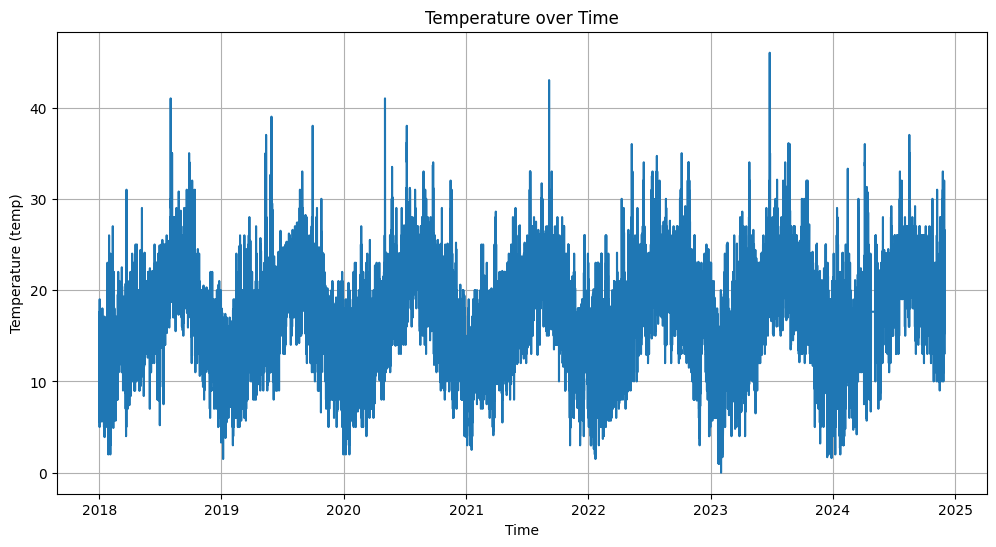

In [ ]:
# prompt: plot temp over time

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['temp'])
plt.xlabel('Time')
plt.ylabel('Temperature (temp)')
plt.title('Temperature over Time')
plt.grid(True)
plt.show()


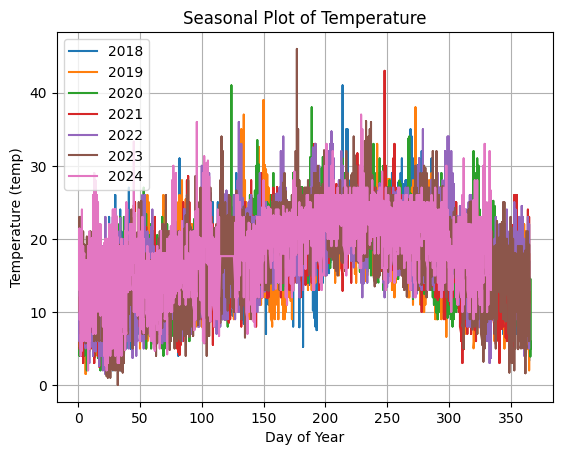

In [ ]:
# prompt: make a seasonal plot  each year with a different color

import matplotlib.pyplot as plt

# Group the data by year
years = df['time'].dt.year.unique()
for year in years:
  df_year = df[df['time'].dt.year == year]
  plt.plot(df_year['time'].dt.dayofyear, df_year['temp'], label=str(year))

plt.xlabel('Day of Year')
plt.ylabel('Temperature (temp)')
plt.title('Seasonal Plot of Temperature')
plt.grid(True)
plt.legend()
plt.show()




# > **A clear yearly seasonality we're going to add fourier features**



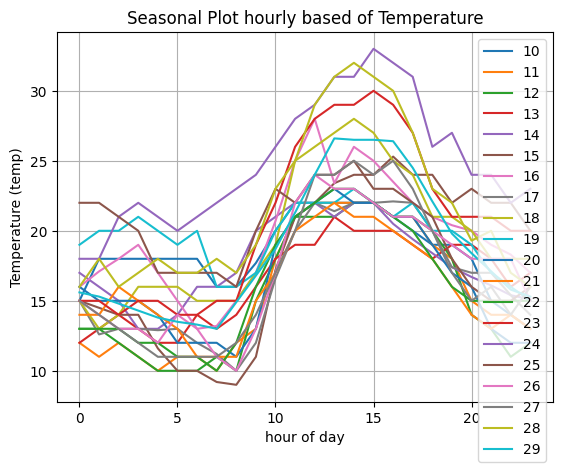

In [ ]:
# prompt: the dataset that I have is hourly based take the last 30 days and make a daily seasonal plot to spot the seasonality of the day depending on the hour of the day

n = 20
# Select the last n days of data
last_n_days = df.tail(n * 24)  # Assuming hourly data
days = last_n_days['time'].dt.day.unique()
for day in days:
  df_day = last_n_days[last_n_days['time'].dt.day == day]
  plt.plot(df_day['time'].dt.hour, df_day['temp'], label=str(day))

plt.xlabel('hour of day')
plt.ylabel('Temperature (temp)')
plt.title('Seasonal Plot hourly based of Temperature')
plt.grid(True)
plt.legend()
plt.show()



there is an daily seasonality we should address it also with fourier feature and seasonal indicators

# ***starting with hourly seasonality***
lets add a seasonal indicator

In [ ]:
df['hour_of_day'] = df['time'].dt.hour
df.tail()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,hour_of_day
60595,2024-11-29 19:00:00,19.8,13.3,66.0,0.0,87.0,5.5,1023.9,19
60596,2024-11-29 20:00:00,18.4,12.8,70.0,0.0,91.0,3.7,1024.1,20
60597,2024-11-29 21:00:00,17.1,12.2,73.0,0.0,98.0,3.7,1024.3,21
60598,2024-11-29 22:00:00,15.8,11.8,77.0,0.0,107.0,1.8,1024.5,22
60599,2024-11-29 23:00:00,15.3,11.3,77.0,0.0,106.0,1.8,1024.5,23


now let's add fourier features

In [ ]:
# hourly
freq = 24
order = 2
seasonal_features = fourier_features(df.index, freq, order)
df = pd.concat([df, seasonal_features], axis=1)
# yearly
freq = 365 * 24
order = 2
seasonal_features = fourier_features(df.index, freq, order)
df = pd.concat([df, seasonal_features], axis=1)
df.tail()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,hour_of_day,sin_24_1,cos_24_1,sin_24_2,cos_24_2,sin_8760_1,cos_8760_1,sin_8760_2,cos_8760_2
60595,2024-11-29 19:00:00,19.8,13.3,66.0,0.0,87.0,5.5,1023.9,19,-0.965926,0.258819,-0.500000,-8.660254e-01,-0.496891,0.867813,-0.862417,0.506199
60596,2024-11-29 20:00:00,18.4,12.8,70.0,0.0,91.0,3.7,1024.1,20,-0.866025,0.500000,-0.866025,-5.000000e-01,-0.496268,0.868169,-0.861690,0.507435
60597,2024-11-29 21:00:00,17.1,12.2,73.0,0.0,98.0,3.7,1024.3,21,-0.707107,0.707107,-1.000000,-4.912114e-12,-0.495646,0.868525,-0.860961,0.508671
60598,2024-11-29 22:00:00,15.8,11.8,77.0,0.0,107.0,1.8,1024.5,22,-0.500000,0.866025,-0.866025,5.000000e-01,-0.495022,0.868880,-0.860230,0.509905
60599,2024-11-29 23:00:00,15.3,11.3,77.0,0.0,106.0,1.8,1024.5,23,-0.258819,0.965926,-0.500000,8.660254e-01,-0.494399,0.869235,-0.859498,0.511139


# **let's explore serial dependancy (cycles)**

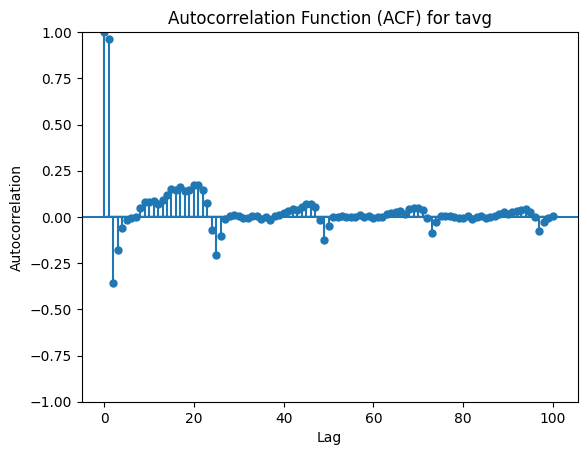

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Assuming 'df' is your DataFrame and 'tavg' is the column of interest
plot_pacf(df['temp'], lags=100)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) for tavg')
plt.show()

# **TODO/ add cross lag features**

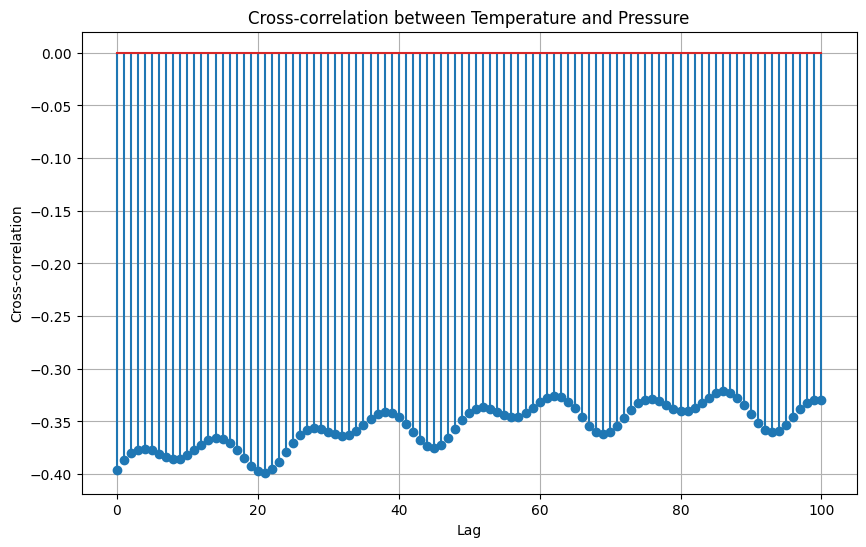

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# Assuming 'df' is your DataFrame with 'temp' and 'pressure' columns
temperature = df['temp']
pressure = df['pres']

# Compute cross-correlation function (CCF) between temperature and pressure
lags = 100  # Number of lags to compute
cross_corr = ccf(temperature, pressure)[:lags+1]  # Get cross-correlation for up to 'lags'

# Plot the cross-correlation function
plt.figure(figsize=(10, 6))
plt.stem(range(lags+1), cross_corr)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between Temperature and Pressure')
plt.grid(True)
plt.show()


lets add 80 lag features



In [ ]:
# Add lagged features
for i in range(0, 80):
  df[f'temp_lag_{i}'] = df['temp'].shift(i)
df.dropna(inplace=True)

In [ ]:
df.tail()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,hour_of_day,sin_24_1,...,temp_lag_70,temp_lag_71,temp_lag_72,temp_lag_73,temp_lag_74,temp_lag_75,temp_lag_76,temp_lag_77,temp_lag_78,temp_lag_79
60595,2024-11-29 19:00:00,19.8,13.3,66.0,0.0,87.0,5.5,1023.9,19,-0.965926,...,18.0,18.0,19.0,20.0,21.0,21.0,22.0,23.0,23.0,24.0
60596,2024-11-29 20:00:00,18.4,12.8,70.0,0.0,91.0,3.7,1024.1,20,-0.866025,...,18.0,18.0,18.0,19.0,20.0,21.0,21.0,22.0,23.0,23.0
60597,2024-11-29 21:00:00,17.1,12.2,73.0,0.0,98.0,3.7,1024.3,21,-0.707107,...,15.0,18.0,18.0,18.0,19.0,20.0,21.0,21.0,22.0,23.0
60598,2024-11-29 22:00:00,15.8,11.8,77.0,0.0,107.0,1.8,1024.5,22,-0.500000,...,15.0,15.0,18.0,18.0,18.0,19.0,20.0,21.0,21.0,22.0
60599,2024-11-29 23:00:00,15.3,11.3,77.0,0.0,106.0,1.8,1024.5,23,-0.258819,...,14.0,15.0,15.0,18.0,18.0,18.0,19.0,20.0,21.0,21.0


In [ ]:
df['temp_lag_0']

,temp_lag_0
79,14.0
80,14.0
81,14.0
82,14.0
83,15.0
...,...
60595,19.8
60596,18.4
60597,17.1
60598,15.8


test the model

In [ ]:
from sklearn.model_selection import train_test_split

# drop the date and store it in a date variable
date = df['time']
df = df.drop('time', axis=1)
df.head()
df = df[sorted(df.columns)]

In [ ]:
# Split the data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.3, shuffle=False)

In [ ]:
# Define the features (X) and target variable (y)
features = [col for col in df.columns if col != 'temp']
X_train = train_data[features]
y_train = train_data['temp']

In [ ]:
X_train.columns.tolist()

['cos_24_1',
 'cos_24_2',
 'cos_8760_1',
 'cos_8760_2',
 'dwpt',
 'hour_of_day',
 'prcp',
 'pres',
 'rhum',
 'sin_24_1',
 'sin_24_2',
 'sin_8760_1',
 'sin_8760_2',
 'temp_lag_0',
 'temp_lag_1',
 'temp_lag_10',
 'temp_lag_11',
 'temp_lag_12',
 'temp_lag_13',
 'temp_lag_14',
 'temp_lag_15',
 'temp_lag_16',
 'temp_lag_17',
 'temp_lag_18',
 'temp_lag_19',
 'temp_lag_2',
 'temp_lag_20',
 'temp_lag_21',
 'temp_lag_22',
 'temp_lag_23',
 'temp_lag_24',
 'temp_lag_25',
 'temp_lag_26',
 'temp_lag_27',
 'temp_lag_28',
 'temp_lag_29',
 'temp_lag_3',
 'temp_lag_30',
 'temp_lag_31',
 'temp_lag_32',
 'temp_lag_33',
 'temp_lag_34',
 'temp_lag_35',
 'temp_lag_36',
 'temp_lag_37',
 'temp_lag_38',
 'temp_lag_39',
 'temp_lag_4',
 'temp_lag_40',
 'temp_lag_41',
 'temp_lag_42',
 'temp_lag_43',
 'temp_lag_44',
 'temp_lag_45',
 'temp_lag_46',
 'temp_lag_47',
 'temp_lag_48',
 'temp_lag_49',
 'temp_lag_5',
 'temp_lag_50',
 'temp_lag_51',
 'temp_lag_52',
 'temp_lag_53',
 'temp_lag_54',
 'temp_lag_55',
 'temp_lag

In [ ]:

from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Define the features (X) for the test set
X_test = test_data[features]

# Make predictions on the test set
linear_predictions = linear_model.predict(X_test)

In [ ]:
# prompt: print some evaluation metrecies

from sklearn.metrics import mean_squared_error, mean_absolute_error


# Calculate evaluation metrics for Linearmodel
mse_linear = mean_squared_error(test_data['temp'], linear_predictions)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(test_data['temp'], linear_predictions)

print("Mean Squared Error (MSE):", mse_linear)
print("Root Mean Squared Error (RMSE):", rmse_linear)
print("Mean Absolute Error (MAE):", mae_linear)


Mean Squared Error (MSE): 1.960376474023368e-27
Root Mean Squared Error (RMSE): 4.427613887889693e-14
Mean Absolute Error (MAE): 2.4108152450941607e-14


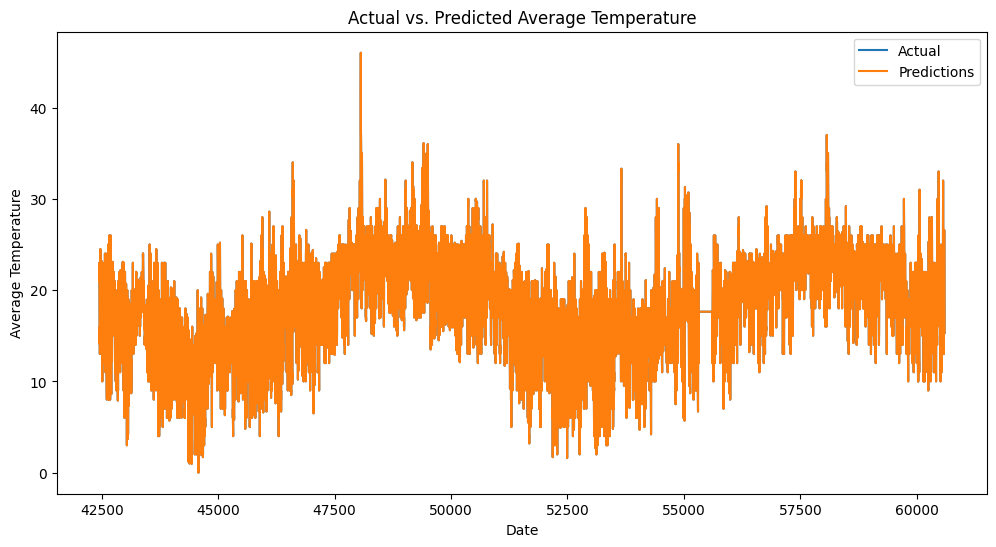

In [ ]:
# prompt: plot the predictions against the actual values
import matplotlib.pyplot as plt

# Plot predictions against actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['temp'], label='Actual')
plt.plot(test_data.index, linear_predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Actual vs. Predicted Average Temperature')
plt.legend()
plt.show()

Step 1: MSE: 0.00, RMSE: 0.00, MAE: 0.00
Step 2: MSE: 1.27, RMSE: 1.13, MAE: 0.82
Step 3: MSE: 2.45, RMSE: 1.57, MAE: 1.16
Step 4: MSE: 3.41, RMSE: 1.85, MAE: 1.38
Step 5: MSE: 4.12, RMSE: 2.03, MAE: 1.52
Step 6: MSE: 4.62, RMSE: 2.15, MAE: 1.62
Step 7: MSE: 4.98, RMSE: 2.23, MAE: 1.68
Step 8: MSE: 5.30, RMSE: 2.30, MAE: 1.72
Step 9: MSE: 5.57, RMSE: 2.36, MAE: 1.76
Step 10: MSE: 5.79, RMSE: 2.41, MAE: 1.78
Step 11: MSE: 5.85, RMSE: 2.42, MAE: 1.79
Step 12: MSE: 5.97, RMSE: 2.44, MAE: 1.80
Step 13: MSE: 5.98, RMSE: 2.45, MAE: 1.80
Step 14: MSE: 5.94, RMSE: 2.44, MAE: 1.80
Step 15: MSE: 5.95, RMSE: 2.44, MAE: 1.80
Step 16: MSE: 5.90, RMSE: 2.43, MAE: 1.79
Step 17: MSE: 5.88, RMSE: 2.42, MAE: 1.79
Step 18: MSE: 5.93, RMSE: 2.44, MAE: 1.79
Step 19: MSE: 6.00, RMSE: 2.45, MAE: 1.80
Step 20: MSE: 6.12, RMSE: 2.47, MAE: 1.81
Step 21: MSE: 6.28, RMSE: 2.51, MAE: 1.82
Step 22: MSE: 6.19, RMSE: 2.49, MAE: 1.81
Step 23: MSE: 6.20, RMSE: 2.49, MAE: 1.82
Step 24: MSE: 6.12, RMSE: 2.47, MAE: 1.81


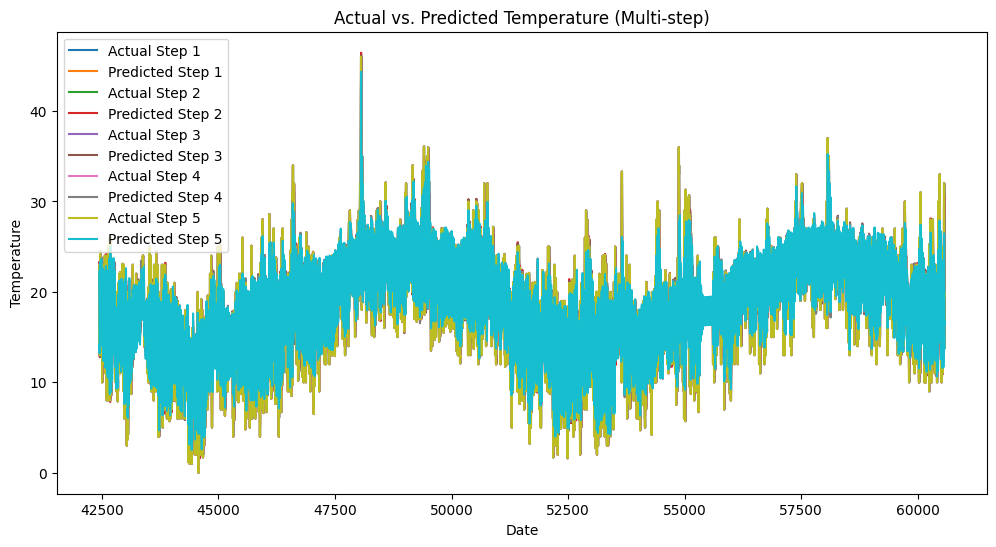

In [ ]:
# prompt: make a model that predicts with 24 steps predicts the next 24

# Assuming you want to predict the next 24 steps of 'temp_y'

# Create a multi-step target for the next 24 steps
y_train_multistep = make_multistep_target(y_train, 24)
y_test_multistep = make_multistep_target(test_data['temp'], 24)


# Drop rows with NaN values in the multi-step target
X_train_multistep = X_train.loc[y_train_multistep.dropna().index]
y_train_multistep = y_train_multistep.dropna()

X_test_multistep = X_test.loc[y_test_multistep.dropna().index]
y_test_multistep = y_test_multistep.dropna()


# Train a new model for multi-step prediction (e.g., Linear Regression)
linear_model_multistep = LinearRegression()
linear_model_multistep.fit(X_train_multistep, y_train_multistep)


# Make multi-step predictions on the test set
multistep_predictions = linear_model_multistep.predict(X_test_multistep)

# Evaluate the multi-step predictions (e.g., using MSE, RMSE, MAE)
# For example, calculate metrics for each step:
for i in range(24):
    mse_multistep = mean_squared_error(y_test_multistep[f'y_step_{i + 1}'], multistep_predictions[:, i])
    rmse_multistep = np.sqrt(mse_multistep)
    mae_multistep = mean_absolute_error(y_test_multistep[f'y_step_{i + 1}'], multistep_predictions[:, i])
    print(f"Step {i+1}: MSE: {mse_multistep:.2f}, RMSE: {rmse_multistep:.2f}, MAE: {mae_multistep:.2f}")

# Plot the multi-step predictions for a few steps
plt.figure(figsize=(12, 6))
for i in range(5):  # Plot the first 5 steps
    plt.plot(y_test_multistep.index, y_test_multistep[f'y_step_{i + 1}'], label=f'Actual Step {i + 1}')
    plt.plot(y_test_multistep.index, multistep_predictions[:, i], label=f'Predicted Step {i + 1}')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperature (Multi-step)')
plt.legend()
plt.show()

# **final training**

In [ ]:
# prompt: train the multiple step model model on all the dataset the test and train

# Assuming you want to train the multi-step model on the entire dataset

# Combine train and test data
X_all = df[features]
y_all = df['temp']

# Create multi-step target for the entire dataset
y_all_multistep = make_multistep_target(y_all, 24)

# Drop rows with NaN values in the multi-step target
X_all_multistep = X_all.loc[y_all_multistep.dropna().index]
y_all_multistep = y_all_multistep.dropna()


# Train the multi-step model on the entire dataset
linear_model_multistep_final = LinearRegression()
linear_model_multistep_final.fit(X_all_multistep, y_all_multistep)


# Now you can use this trained model 'linear_model_multistep_final' for predictions on new data or future steps.
# You can also evaluate its performance on the entire dataset if you want to assess its overall accuracy.

# Example of making multi-step predictions on the entire dataset (for evaluation)
multistep_predictions_all = linear_model_multistep_final.predict(X_all_multistep)

# Evaluate the multi-step predictions on the entire dataset
for i in range(24):
    mse_multistep_all = mean_squared_error(y_all_multistep[f'y_step_{i + 1}'], multistep_predictions_all[:, i])
    rmse_multistep_all = np.sqrt(mse_multistep_all)
    mae_multistep_all = mean_absolute_error(y_all_multistep[f'y_step_{i + 1}'], multistep_predictions_all[:, i])
    print(f"Step {i+1}: MSE: {mse_multistep_all:.2f}, RMSE: {rmse_multistep_all:.2f}, MAE: {mae_multistep_all:.2f}")

# You can further analyze the results and potentially improve the model by exploring different features, models, or hyperparameters.

Step 1: MSE: 0.00, RMSE: 0.00, MAE: 0.00
Step 2: MSE: 1.22, RMSE: 1.10, MAE: 0.79
Step 3: MSE: 2.21, RMSE: 1.49, MAE: 1.09
Step 4: MSE: 3.00, RMSE: 1.73, MAE: 1.29
Step 5: MSE: 3.60, RMSE: 1.90, MAE: 1.42
Step 6: MSE: 4.02, RMSE: 2.01, MAE: 1.50
Step 7: MSE: 4.32, RMSE: 2.08, MAE: 1.56
Step 8: MSE: 4.56, RMSE: 2.13, MAE: 1.60
Step 9: MSE: 4.73, RMSE: 2.17, MAE: 1.62
Step 10: MSE: 4.83, RMSE: 2.20, MAE: 1.64
Step 11: MSE: 4.91, RMSE: 2.22, MAE: 1.65
Step 12: MSE: 4.97, RMSE: 2.23, MAE: 1.66
Step 13: MSE: 5.00, RMSE: 2.24, MAE: 1.66
Step 14: MSE: 5.03, RMSE: 2.24, MAE: 1.67
Step 15: MSE: 5.05, RMSE: 2.25, MAE: 1.67
Step 16: MSE: 5.05, RMSE: 2.25, MAE: 1.67
Step 17: MSE: 5.06, RMSE: 2.25, MAE: 1.67
Step 18: MSE: 5.06, RMSE: 2.25, MAE: 1.66
Step 19: MSE: 5.07, RMSE: 2.25, MAE: 1.66
Step 20: MSE: 5.09, RMSE: 2.26, MAE: 1.67
Step 21: MSE: 5.11, RMSE: 2.26, MAE: 1.67
Step 22: MSE: 5.13, RMSE: 2.26, MAE: 1.67
Step 23: MSE: 5.15, RMSE: 2.27, MAE: 1.67
Step 24: MSE: 5.18, RMSE: 2.28, MAE: 1.68


# **Now making a function for predictions**

In [ ]:
X_train_multistep

,cos_24_1,cos_24_2,cos_8760_1,cos_8760_2,dwpt,hour_of_day,prcp,pres,rhum,sin_24_1,...,temp_lag_74,temp_lag_75,temp_lag_76,temp_lag_77,temp_lag_78,temp_lag_79,temp_lag_8,temp_lag_9,wdir,wspd
79,-0.258819,-8.660254e-01,0.998395,0.993585,12.0,7,0.0,1031.0,88.0,0.965926,...,11.0,12.0,11.8,12.0,12.0,12.5,15.0,15.0,190.000000,3.6
80,-0.500000,-5.000000e-01,0.998354,0.993422,12.0,8,0.0,1031.0,88.0,0.866025,...,10.6,11.0,12.0,11.8,12.0,12.0,14.5,15.0,200.000000,1.8
81,-0.707107,-3.429630e-15,0.998313,0.993257,11.5,9,0.0,1032.0,85.0,0.707107,...,10.0,10.6,11.0,12.0,11.8,12.0,14.0,14.5,120.000000,3.6
82,-0.866025,5.000000e-01,0.998271,0.993090,12.0,10,0.0,1032.0,88.0,0.500000,...,10.0,10.0,10.6,11.0,12.0,11.8,14.0,14.0,185.982799,5.4
83,-0.965926,8.660254e-01,0.998228,0.992920,11.0,11,0.0,1032.0,77.0,0.258819,...,11.5,10.0,10.0,10.6,11.0,12.0,14.3,14.0,140.000000,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42415,-0.258819,-8.660254e-01,0.545842,-0.404114,14.4,7,0.0,1022.0,99.0,0.965926,...,17.0,17.8,17.0,20.0,19.5,17.0,14.0,14.4,0.000000,0.0
42416,-0.500000,-5.000000e-01,0.546442,-0.402801,14.0,8,0.0,1022.0,100.0,0.866025,...,16.0,17.0,17.8,17.0,20.0,19.5,14.0,14.0,0.000000,0.0
42417,-0.707107,-1.578083e-12,0.547043,-0.401488,15.0,9,0.0,1023.0,94.0,0.707107,...,20.0,16.0,17.0,17.8,17.0,20.0,13.2,14.0,0.000000,0.0
42418,-0.866025,5.000000e-01,0.547643,-0.400174,18.8,10,0.0,1023.7,99.0,0.500000,...,20.0,20.0,16.0,17.0,17.8,17.0,13.0,13.2,140.000000,9.4


In [ ]:
# prompt: now I want to give the model a date (the last date in X_train_multistep) and it should predict the next 24h

# Assuming you have X_train_multistep and y_train_multistep defined as in your code
# and you have a trained model (linear_model_multistep)

from  datetime import timedelta

def predict_next_24h(model, X_train_multistep, dateindex):
  """
  Predicts the next 24 hours of temperature based on the given date.

  Args:
    model: The trained model for multi-step prediction.
    X_train_multistep: The features used for training the model.
    date_str: The date string (e.g., '2023-12-01 12:00:00') for which to make the prediction.

  Returns:
    A NumPy array of predicted temperatures for the next 24 hours.
  """

  # Convert date string to datetime object

  # Find the row in X_train_multistep corresponding to the given date
  # Assuming your 'date' variable contains the datetime index
  try:
    input_features = X_train_multistep.loc[dateindex]
  except IndexError:
    print(f"Date {dateindex} not found in training data.")
    return None

  # Make the prediction using the model
  return pd.DataFrame(input_features).T
  # predictions = model.predict(pd.DataFrame(input_features).T)

  # return predictions[0]  # Return the predictions for the next 24 hours

# Example usage:
# Assuming you have X_train_multistep and linear_model_multistep defined
last_date_in_data = X_all.index[-1]
predictions_for_next_24h = predict_next_24h(linear_model_multistep_final, X_all, last_date_in_data)

print(predictions_for_next_24h.shape)
# if predictions_for_next_24h is not None:
#   print("Predictions for the next 24 hours starting from", date.loc[last_date_in_data], ":")
#   for i, prediction in enumerate(predictions_for_next_24h):
#     print(f"Step {date.loc[last_date_in_data] + timedelta(hours=i)}: {prediction}")


(1, 95)


# **suggestions to be done**


1.   VAEs
2.   XGBoost (combine these models)



In [ ]:
# prompt: save a model in a file

import pickle

# Assuming 'linear_model_multistep_final' is your trained model
filename = 'trained_model.sav'
pickle.dump(linear_model_multistep_final, open(filename, 'wb'))

# Later, to load the model:
# loaded_model = pickle.load(open(filename, 'rb'))